# Finding Nearest Neighbour to an image from VAE

Write down proper formulation of the CVAE in terms of stats/variational inference

"find the optimal zy which maximizes the lower bound on the log-likelihood for each class:"

Why do we weight KL divergence and the reconstruction error equally?

** Graph of how optimizing the Reconstruction error and the KL divergence are really negatively correlated for the wrong class **

In [2]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Nicer way to import the module?
sys.path.append(str(Path.cwd().parent))
from utils.loading import load_net
from utils.display import torch_to_np, show_imgs
from models.generative_classify import optimize_latent_cvae, gen_classify_cvae, optimize_latent, gen_classify

import torch
from torch import nn
from torch.autograd import Variable
from torchvision import transforms
from torch.nn import functional as F
import torch.optim as optim

import foolbox
import json
from PIL import Image

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.current_device())

cuda:1
0


In [3]:
model_loc = '/media/rene/data/adv_gen/MNIST/mnist_normal/models/CVAE-1_16_32_64-16-MNIST-10_model_best.pth.tar'
model = load_net(model_loc).to(device).eval()

files_df_loc = '/media/rene/data/adv_gen/MNIST/mnist_normal/files_df.pkl'
with open(files_df_loc, 'rb') as f:
    files_df = pickle.load(f)

## Sampling from the latent space conditioned on different classes

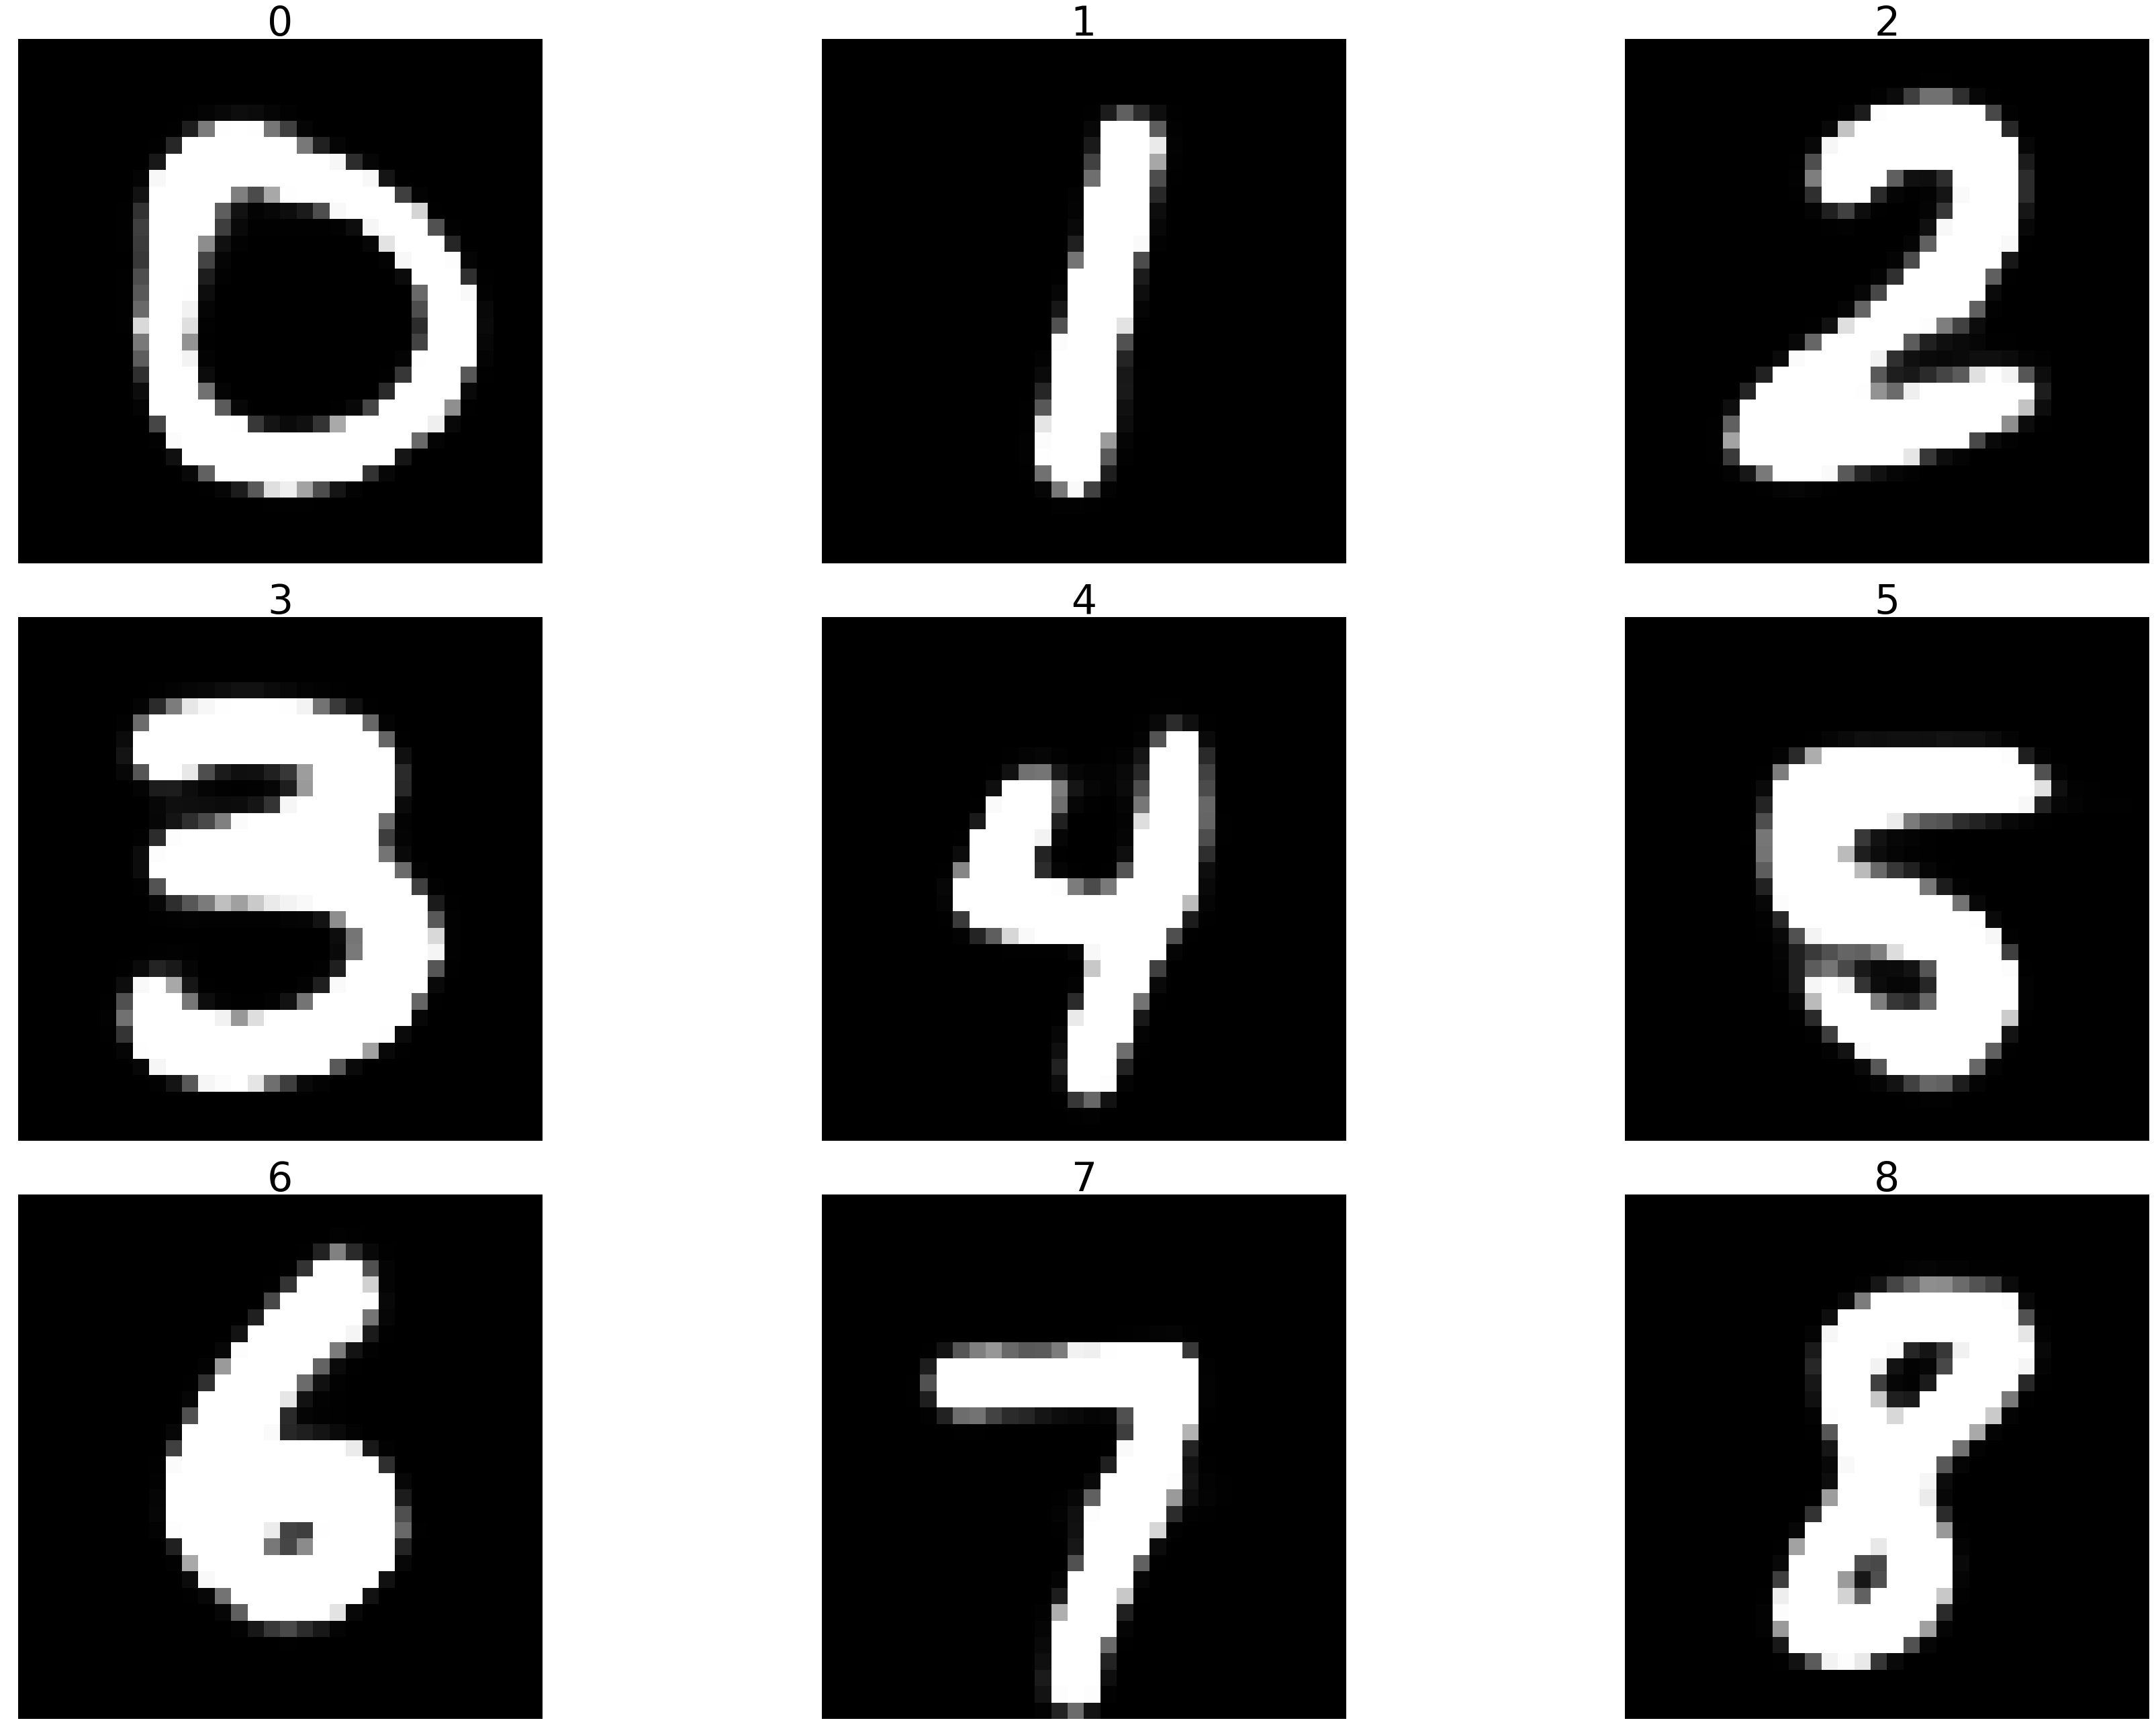

In [4]:
with torch.cuda.device(1):
    num = 9
    randn = np.random.normal(0,1, (num, 16))
    random_latent = torch.from_numpy(randn).type(torch.FloatTensor).to(device)
    labels = torch.from_numpy(np.array(list(range(num)))).type(torch.LongTensor).to(device)
    imgs = model.decode(random_latent, labels)
    labels = torch_to_np(labels)
    show_imgs(imgs, labels, cols = 3)

## Reconstructing one image with different classes
* Clearly easier to reconstruct using the correct class

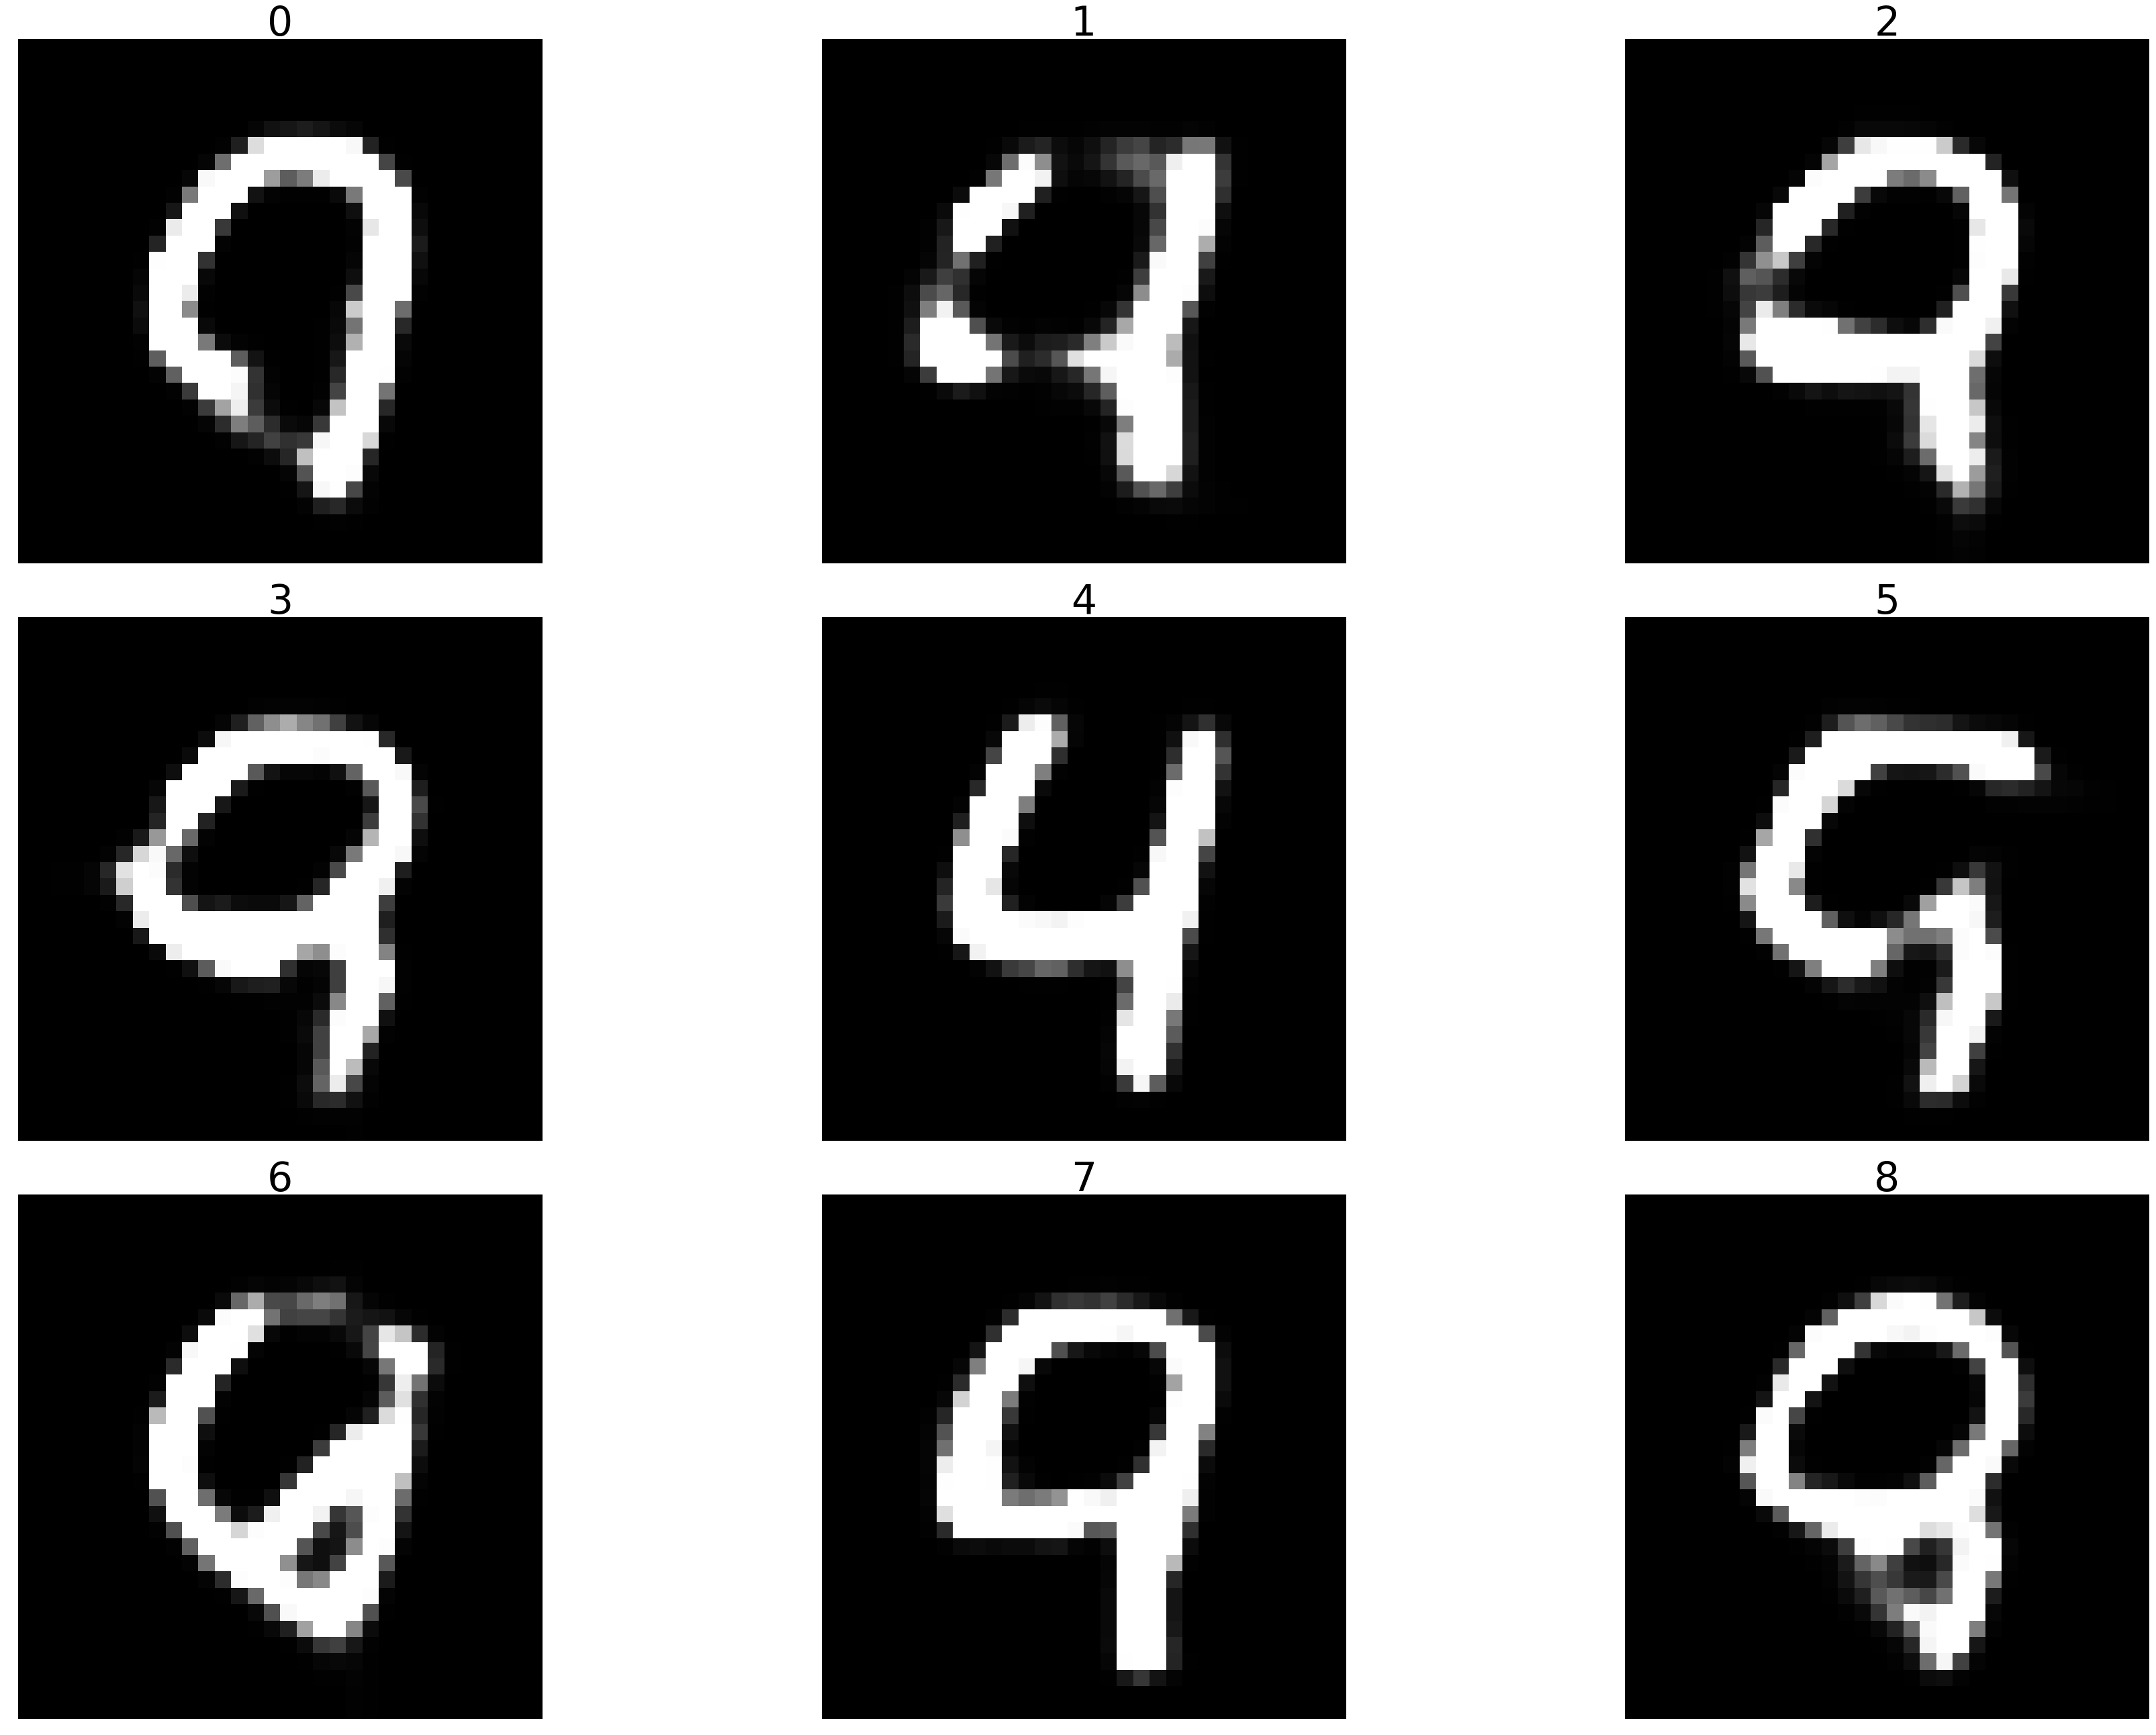

In [5]:
with torch.cuda.device(1):
    img_path = files_df['val'].iloc[4]['path']
    transform = transforms.Compose([
                                    transforms.Resize(32),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])
    
    num = 9
    tensor_labels = torch.from_numpy(np.array(list(range(num)))).type(torch.LongTensor).to(device)
    tensor_img = transform(Image.open(img_path)).unsqueeze(0).to(device)
    tensor_imgs = tensor_img.repeat(num, 1, 1, 1)


    recon_x, mu, logvar = model(tensor_imgs, tensor_labels)      

    labels = torch_to_np(tensor_labels)

show_imgs(recon_x, labels, cols = 3)

## Reproducing an image by doing gradient descent in the latent space
* Minimize the L2 distance + KL between an input image and the output of the generator by doing gradient descent on the latent variables

In [6]:
num_labels = 10
latent_size = 16

rand_mu = np.random.normal(0,1, (1, latent_size))
rand_logvar = np.random.normal(0,1, (1, latent_size))
mu = torch.tensor(rand_mu, device=device, requires_grad=True).type(torch.cuda.FloatTensor)
logvar = torch.tensor(rand_logvar, device=device, requires_grad=True).type(torch.cuda.FloatTensor)
mu = Variable(mu.data, requires_grad=True)
logvar = Variable(logvar.data, requires_grad=True)

img_path = files_df['val'].iloc[5]['path']
img_label = files_df['val'].iloc[5]['class']

transform = transforms.Compose([
                                transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])
tensor_img = transform(Image.open(img_path)).unsqueeze(0).to(device)

img_label 1.0
Label:  0 Loss:  786.19775390625
Label:  1 Loss:  397.6651611328125
Label:  2 Loss:  548.4788818359375
Label:  3 Loss:  572.0785522460938
Label:  4 Loss:  631.3923950195312
Label:  5 Loss:  626.8019409179688
Label:  6 Loss:  640.5679321289062
Label:  7 Loss:  554.5343627929688
Label:  8 Loss:  526.3626708984375


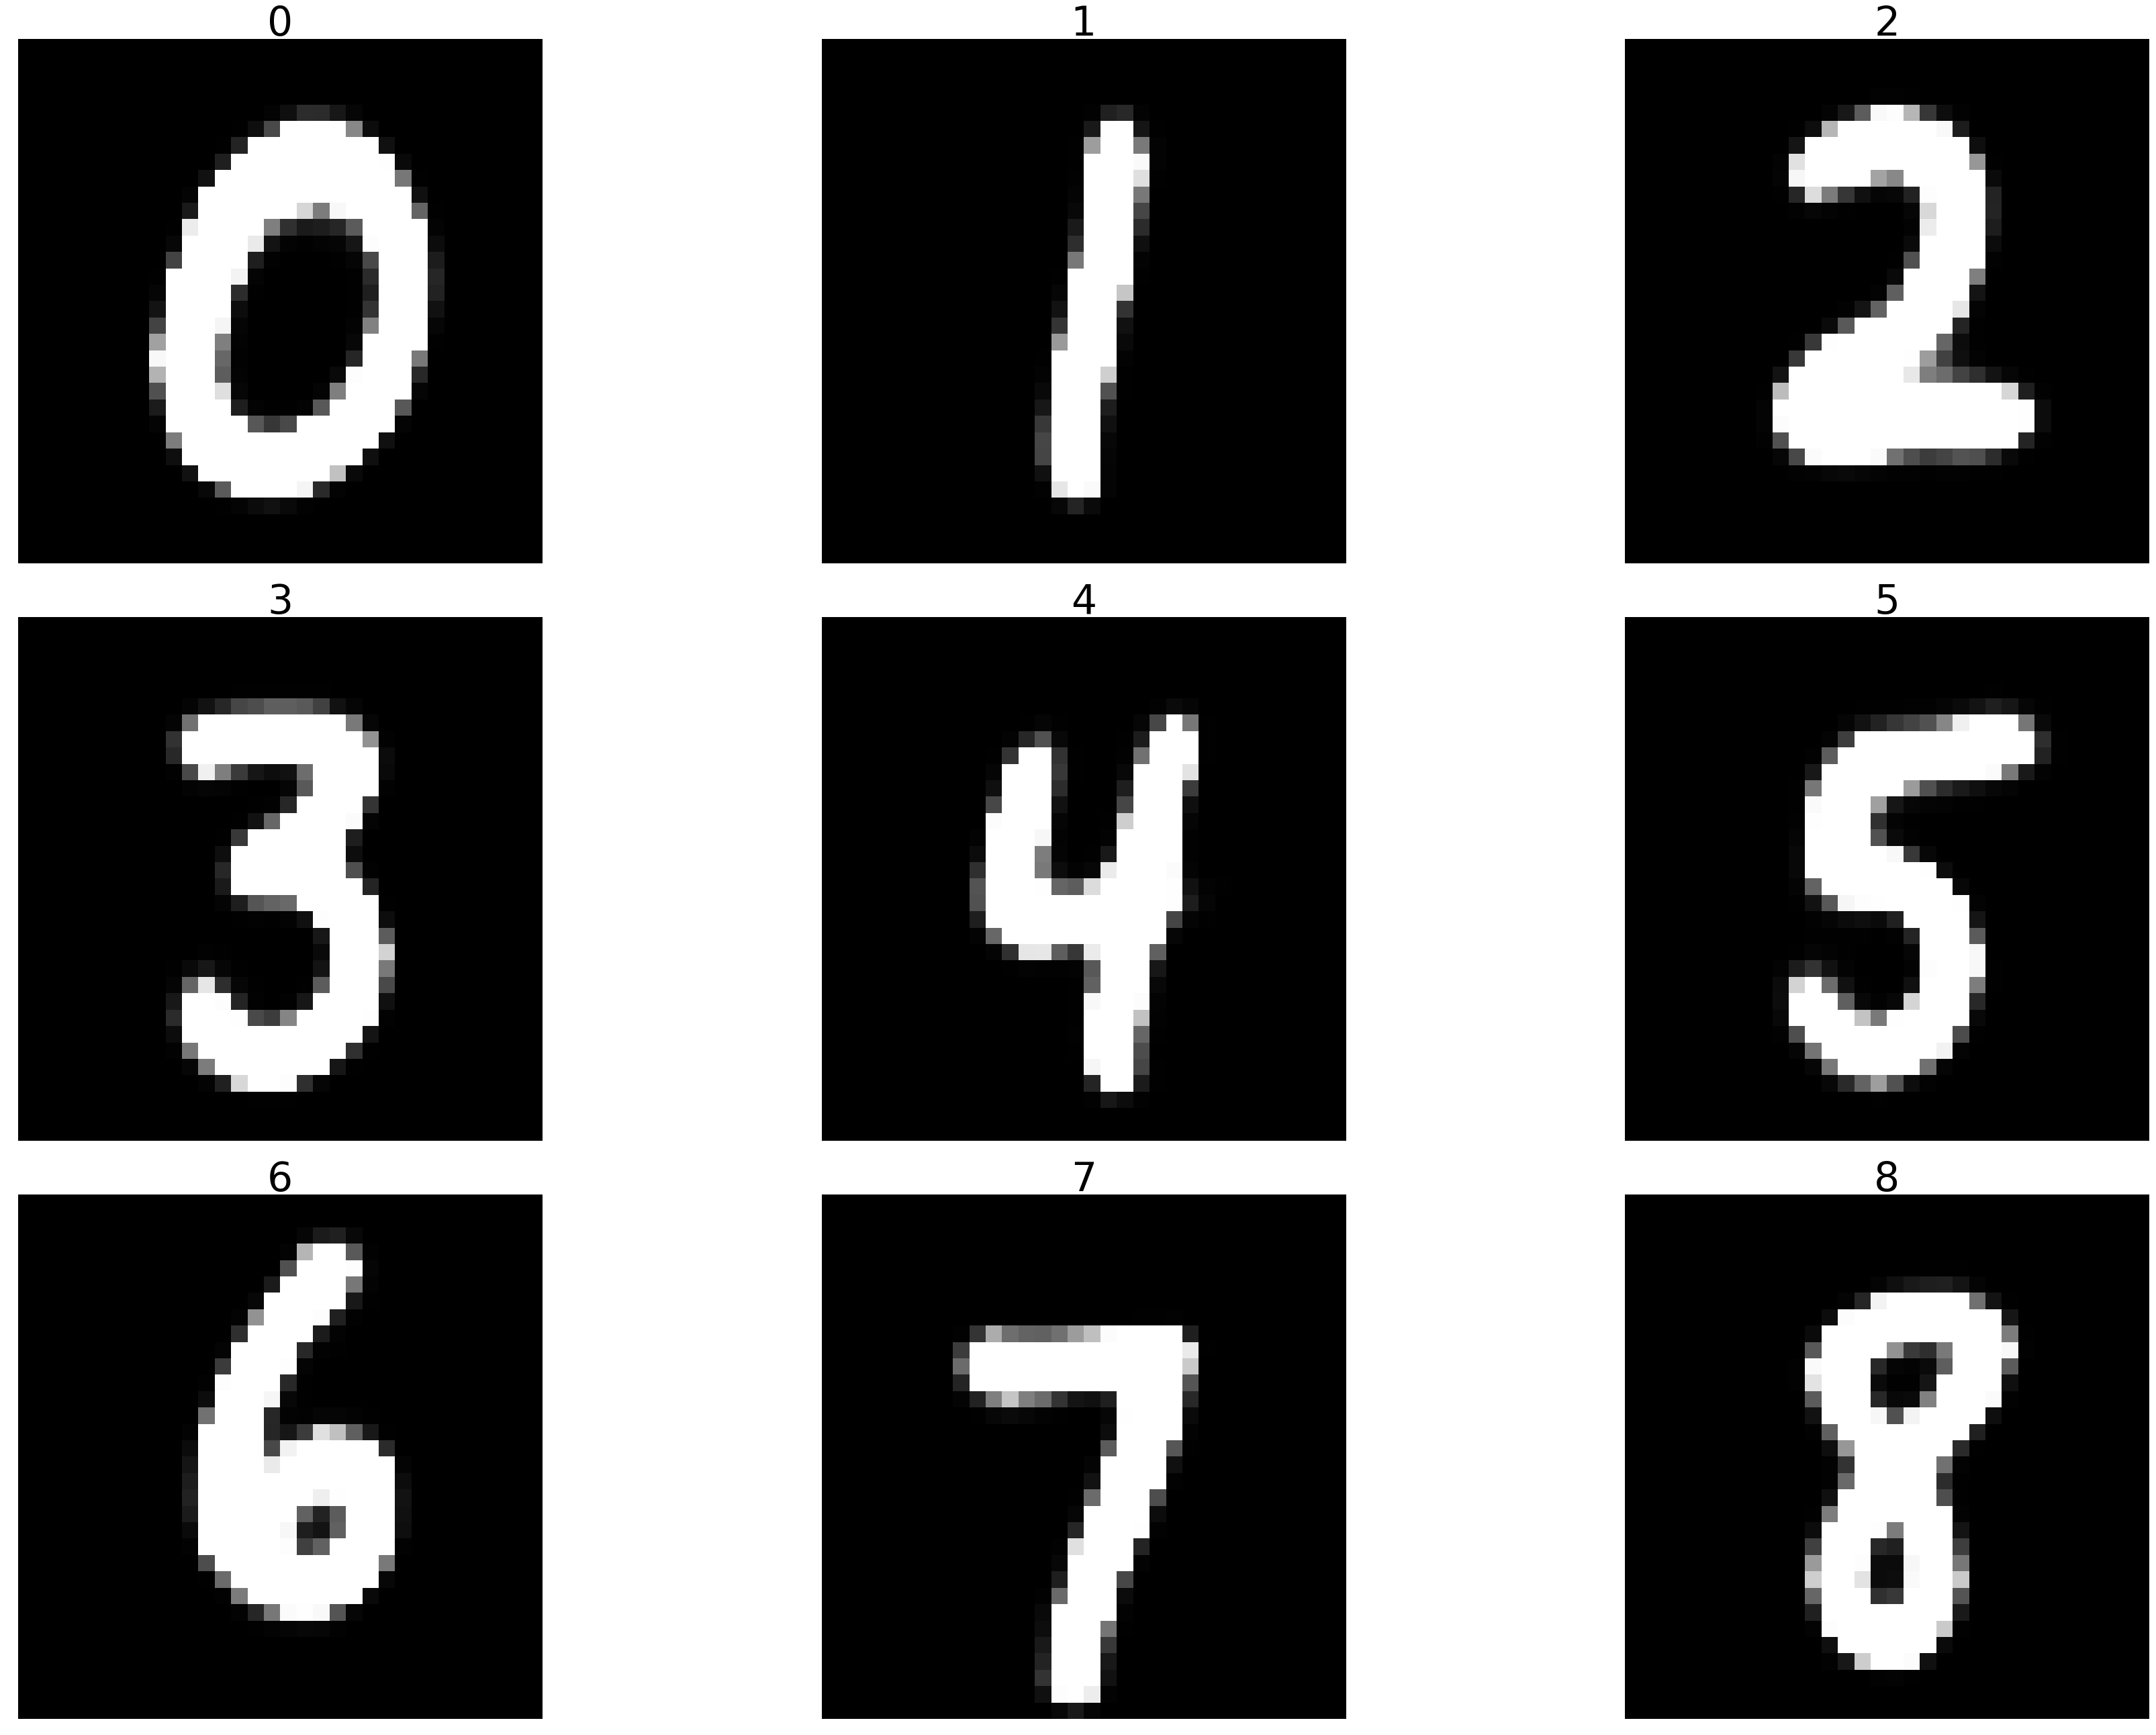

In [8]:
print('img_label', img_label)
with torch.cuda.device(1):
    all_recon = []
    for label in range(num):
        tensor_label = torch.from_numpy(np.array(label)).unsqueeze(0).type(torch.LongTensor).to(device)

        recon_x, z, loss, BCE_list, KLD_list = optimize_latent_cvae(tensor_img, tensor_label, 
                                                                    mu, logvar, model, iterations=50)
        print('Label: ',  label, 'Loss: ', loss.item())

        all_recon.append(torch_to_np(recon_x))
show_imgs(np.array(all_recon), tensor_labels, cols = 3)

## Find the class with minimum reconstruction error
* Random initializations of the latent vectors, perform sgd to reconstruct the input image by minimizing BCE+KL
* Do this for many random initializations for each class, then take the best reconstruction as the classification

Questions
* Why is the error 50% KL and reconstruction?
* Should we be using the sampling, or just use a fized z (like using mu with var=0)
* **Optimizing**: Could initialize the search with the latent encoding of each one in each autoencoder

In [24]:
num_labels = 10
latent_size = 16
num_times = 100

img_path = files_df['val'].iloc[4]['path']
img_label = files_df['val'].iloc[4]['class']
transform = transforms.Compose([
                                transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])
tensor_img = transform(Image.open(img_path)).unsqueeze(0).to(device)
labels = list(range(num_labels))

with torch.cuda.device(1):
    results, predicted_label = gen_classify_cvae(tensor_img, labels, model, num_times=50, 
                                                 iterations=50, latent_size=16, device=device, KLD_weight=1)
    
for label, all_loss in results.items():
    print(f'label: {label}, min loss {np.min(all_loss)}, mean loss {np.mean(all_loss)}')
print(f'Predicted_label: {predicted_label}')
print(f'Actual Label: {img_label}')

label: 0, min loss 633.2393188476562, mean loss 726.76404296875
label: 1, min loss 698.552734375, mean loss 780.9484545898438
label: 2, min loss 559.8345336914062, mean loss 698.2369677734375
label: 3, min loss 668.6343994140625, mean loss 772.9019116210937
label: 4, min loss 408.09228515625, mean loss 563.8674914550782
label: 5, min loss 614.4699096679688, mean loss 738.3203894042969
label: 6, min loss 563.2217407226562, mean loss 697.4825573730469
label: 7, min loss 549.790283203125, mean loss 681.2473779296874
label: 8, min loss 557.9523315429688, mean loss 685.3533605957032
label: 9, min loss 503.5682678222656, mean loss 639.1050067138672
Predicted_label: 4
Actual Label: 4.0


# Normal VAE: One VAE for each label


## Sampling from the latent space for each VAE

* Output is resonable

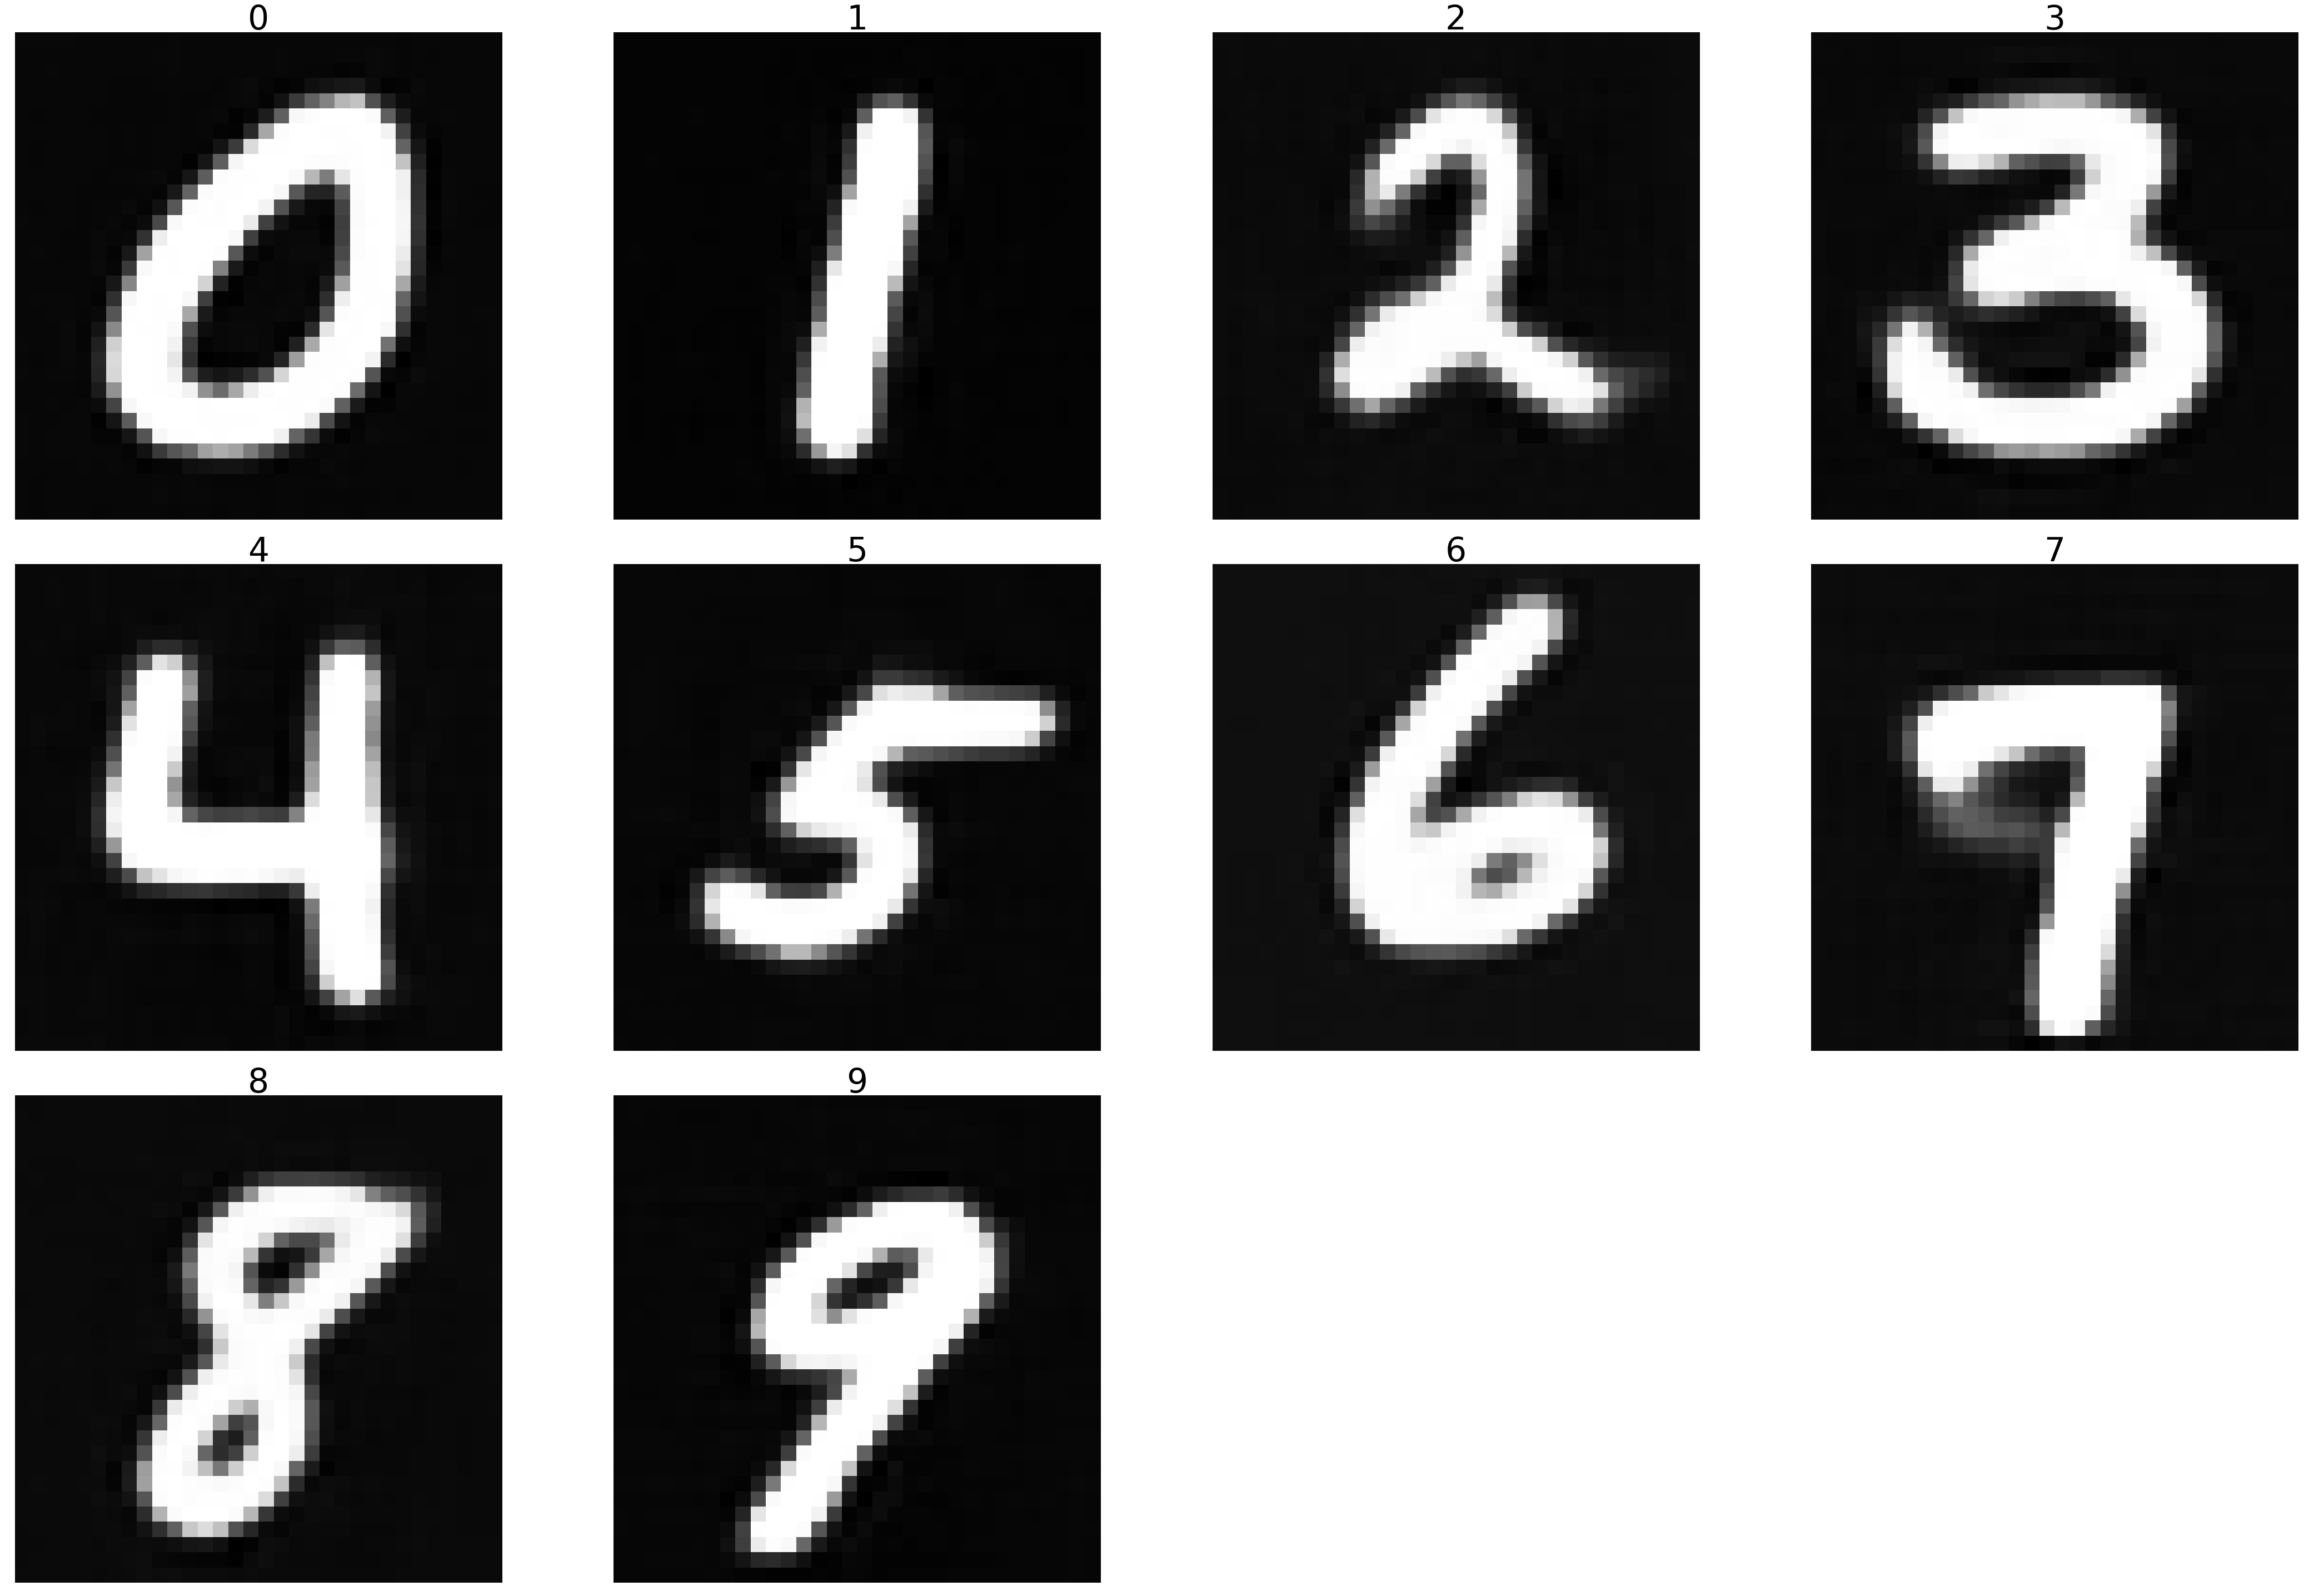

In [25]:
files_df_loc = '/media/rene/data/adv_gen/MNIST/mnist_normal/files_df.pkl'
with open(files_df_loc, 'rb') as f:
    files_df = pickle.load(f)

with torch.cuda.device(1):
    save_path = Path('/media/rene/data/adv_gen/MNIST/mnist_normal/models/')
    all_recon = []
    num = 10

    for label in range(num):
        model_name = 'VAE-1_16_32_64-16-MNIST_label_'+str(label)+'_model_best.pth.tar'
        model_loc = save_path / model_name
        model = load_net(model_loc).to(device).eval()

        randn = np.random.normal(0,1, (1, 16))
        random_latent = torch.from_numpy(randn).type(torch.FloatTensor).to(device)
        tensor_label = torch.from_numpy(np.array(label)).type(torch.LongTensor).to(device)
        recon_x = model.decode(random_latent)
        all_recon.append(torch_to_np(recon_x))
show_imgs(np.array(all_recon), np.array(list(range(num))), cols = 3)

## Reconstruct one image using all the VAEs
* Clearly the correct label one works better

Actual label: 4.0


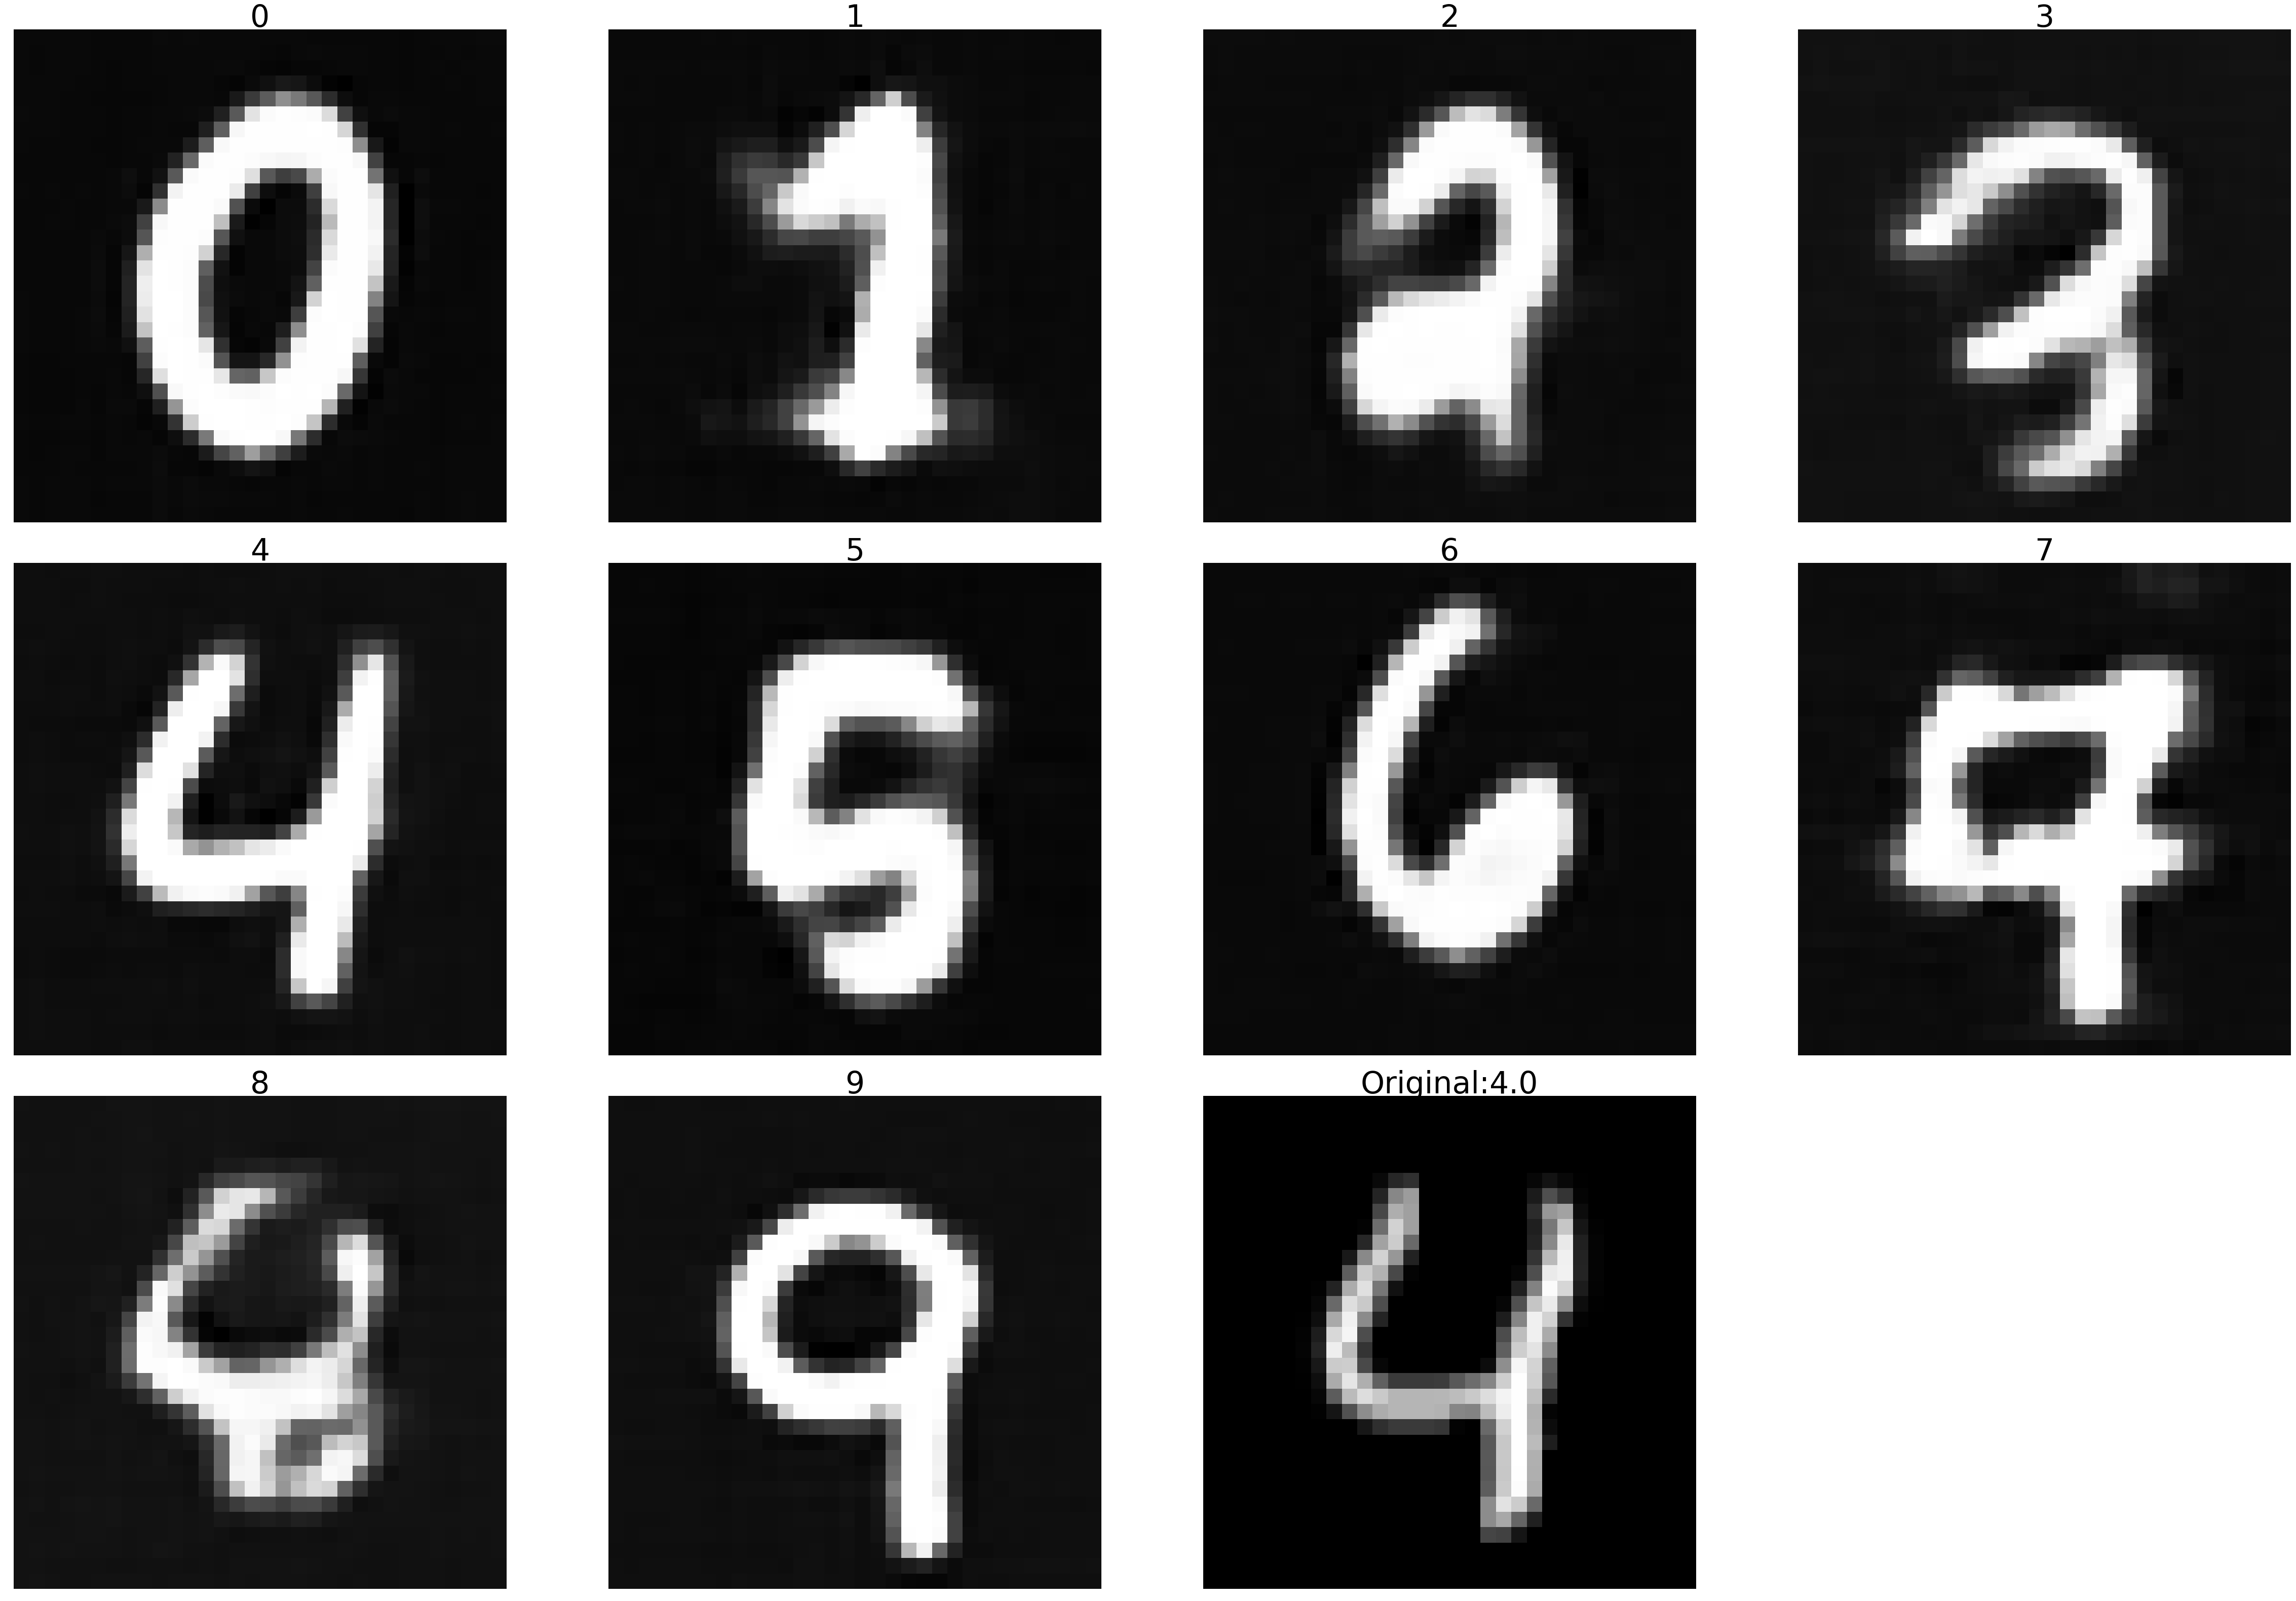

In [31]:
label = files_df['val'].iloc[4]['class']
print(f'Actual label: {label}')
with torch.cuda.device(1):
    img_path = files_df['val'].iloc[4]['path']
    transform = transforms.Compose([
                                    transforms.Resize(32),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])
    
    num = 10
    tensor_labels = torch.from_numpy(np.array(list(range(num)))).type(torch.LongTensor).to(device)
    tensor_img = transform(Image.open(img_path)).unsqueeze(0).to(device)
    
    save_path = Path('/media/rene/data/adv_gen/MNIST/mnist_normal/models/')
    all_recon = []

    for label in range(num):
        model_name = 'VAE-1_16_32_64-16-MNIST_label_'+str(label)+'_model_best.pth.tar'
        model_loc = save_path / model_name
        model = load_net(model_loc).to(device).eval()
        recon_x, mu, logvar = model(tensor_img)
        all_recon.append(torch_to_np(recon_x))

original = torch_to_np(tensor_img)
labels = np.array(list(range(num))+['Original:'+str(files_df['val'].iloc[4]['class'])])
show_imgs(np.array(all_recon+[original]), labels, cols = 3)

## Reproducing an image by doing gradient descent in the latent space
* Try to reconstruct the same image using each VAE

In [27]:
num_labels = 10
latent_size = 16

rand_mu = np.random.normal(0,1, (1, latent_size))
rand_logvar = np.random.normal(0,1, (1, latent_size))
mu = torch.tensor(rand_mu, device=device, requires_grad=True).type(torch.cuda.FloatTensor)
logvar = torch.tensor(rand_logvar, device=device, requires_grad=True).type(torch.cuda.FloatTensor)
mu = Variable(mu.data, requires_grad=True)
logvar = Variable(logvar.data, requires_grad=True)

img_path = files_df['val'].iloc[5]['path']
img_label = files_df['val'].iloc[5]['class']

transform = transforms.Compose([
                                transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])
tensor_img = transform(Image.open(img_path)).unsqueeze(0).to(device)

Label:  0 Loss:  934.9813232421875
Label:  1 Loss:  587.9940185546875
Label:  2 Loss:  945.1310424804688
Label:  3 Loss:  804.444580078125
Label:  4 Loss:  883.111083984375
Label:  5 Loss:  764.2875366210938
Label:  6 Loss:  862.1458129882812
Label:  7 Loss:  824.3638305664062
Label:  8 Loss:  770.3978881835938
Label:  9 Loss:  684.821044921875


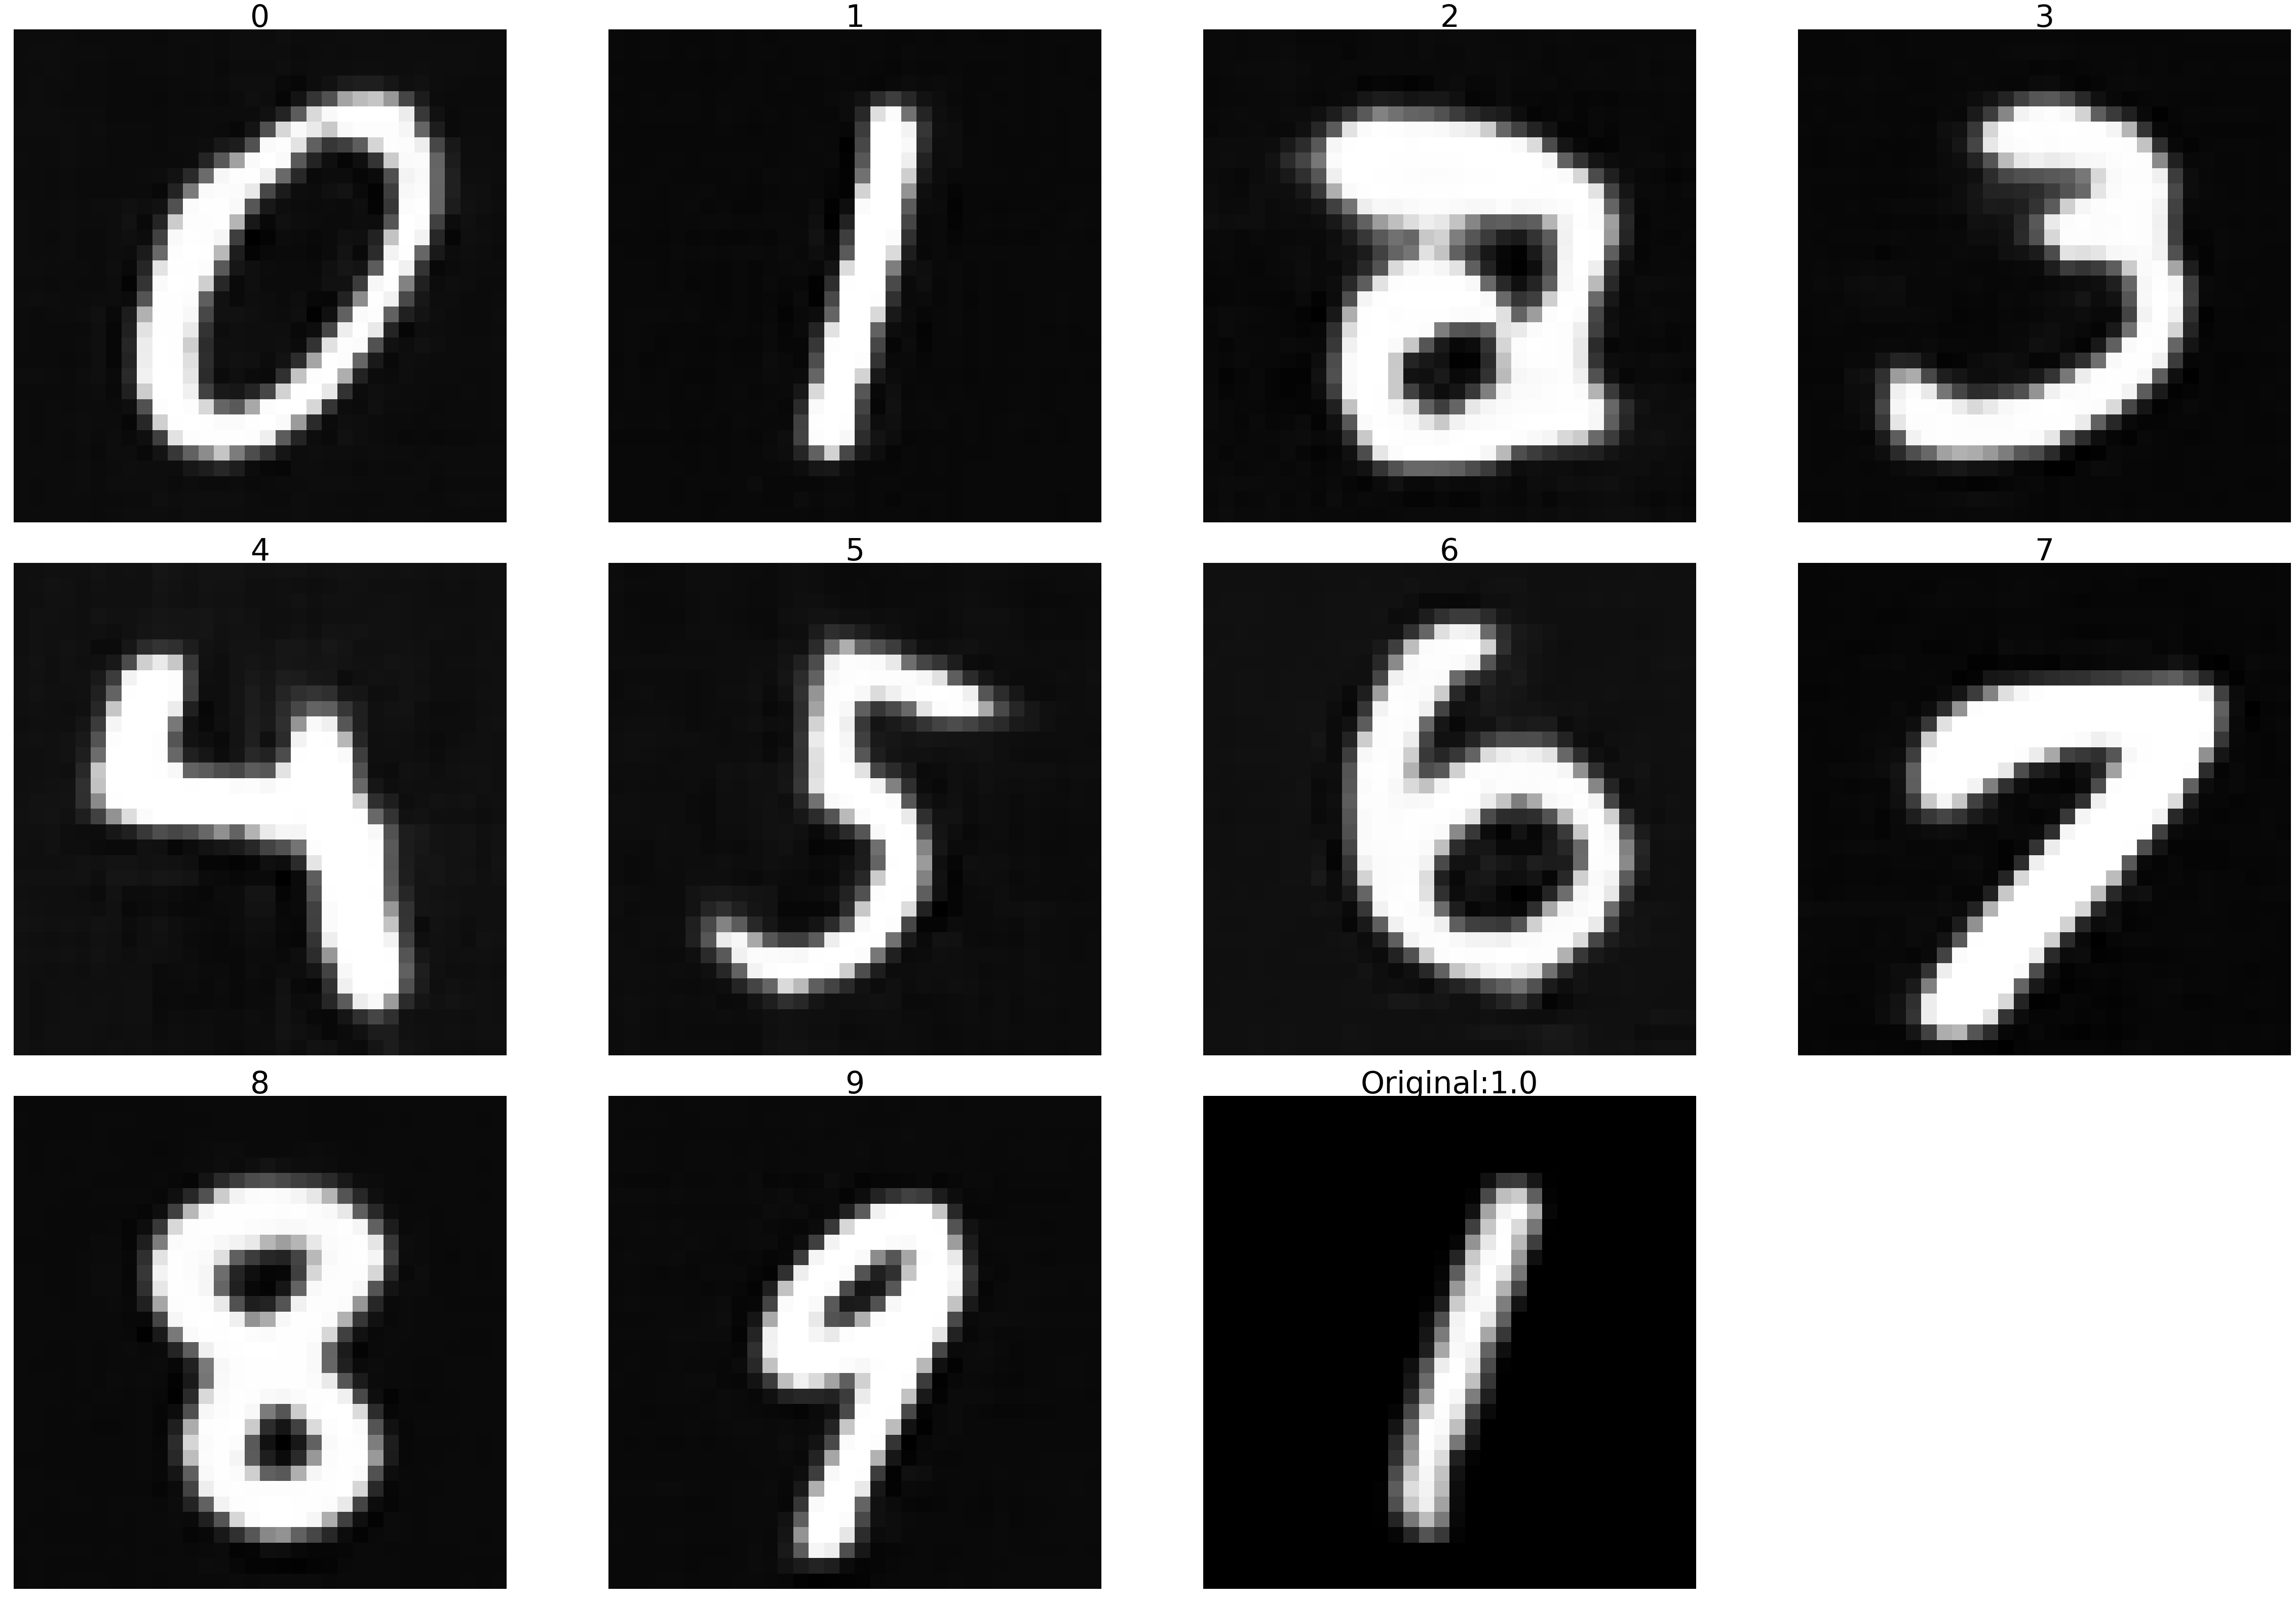

In [28]:
with torch.cuda.device(1):
    save_path = Path('/media/rene/data/adv_gen/MNIST/mnist_normal/models/')
    model_list = []
    all_recon = []

    for label in range(10):
        model_name = 'VAE-1_16_32_64-16-MNIST_label_'+str(label)+'_model_best.pth.tar'
        model_loc = save_path / model_name
        model = load_net(model_loc).to(device).eval()

        recon_x, z, loss, BCE_list, KLD_list = optimize_latent(tensor_img, mu, logvar, model, iterations=50)
        print('Label: ',  label, 'Loss: ', loss.item())
        
        all_recon.append(torch_to_np(recon_x))

original = torch_to_np(tensor_img)
labels = np.array(list(range(num))+['Original:'+str(img_label)])
show_imgs(np.array(all_recon+[original]), labels, cols = 3)

## Classify an image based on reconstruction loss
* Both the lowest min loss and mean loss from correct label (4)

In [30]:
with torch.cuda.device(1):
    img_path = files_df['val'].iloc[4]['path']
    transform = transforms.Compose([
                                    transforms.Resize(32),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])
    tensor_img = transform(Image.open(img_path)).unsqueeze(0).to(device)

    
    save_path = Path('/media/rene/data/adv_gen/MNIST/mnist_normal/models/')
    model_dict = {}
    all_recon = []

    for label in range(num):
        model_name = 'VAE-1_16_32_64-16-MNIST_label_'+str(label)+'_model_best.pth.tar'
        model_loc = save_path / model_name
        model_dict[label] = load_net(model_loc).to(device).eval()
        
    results, label = gen_classify(tensor_img, model_dict,
                                  num_times=50, iterations=50, latent_size=16, device=device)

for label, all_loss in results.items():
    print(f'label: {label}, min loss {np.min(all_loss)}, mean loss {np.mean(all_loss)}')

print('predicted_label', predicted_label)

label: 0, min loss 725.0742797851562, mean loss 834.9614489746094
label: 1, min loss 771.0243530273438, mean loss 842.71453125
label: 2, min loss 715.8361206054688, mean loss 812.8233752441406
label: 3, min loss 724.6439819335938, mean loss 852.2499377441407
label: 4, min loss 616.17529296875, mean loss 736.814970703125
label: 5, min loss 706.8734741210938, mean loss 830.6258264160156
label: 6, min loss 663.739990234375, mean loss 840.7879797363281
label: 7, min loss 686.9098510742188, mean loss 817.27859375
label: 8, min loss 712.9991455078125, mean loss 818.262041015625
label: 9, min loss 626.2748413085938, mean loss 770.4059875488281
predicted_label 4
